<a href="https://colab.research.google.com/github/drscook/REU_2019/blob/master/REU_day_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Math/Psych REU Day 4 - Intro to Python 
### Tarleton State University
### Dr. Scott Cook

This notebook can also be run locally (say on the Anaconda Distribution https://www.anaconda.com/download/).  The google colab option is easiest because it does not require installation and can be used from any computer.

Resources
- https://realpython.com/
- Jake Vanderplas free books
    - Whirlwind Tour of Python - https://github.com/jakevdp/WhirlwindTourOfPython.git
    - Python Data Science Handbook - https://github.com/jakevdp/PythonDataScienceHandbook
    - Can access directly from Colab: File -> open notebook -> github -> paste link
- Google it

Today, I plan to cover more about Numpy using chapter 2 of https://github.com/jakevdp/PythonDataScienceHandbook.

# Review of Day 3

Homework - Here is some code to get us started writing a simple simulation of the Sinai Billiard.  This will set things up and draw a picture.  Your job is to write code that finds the next collision point, move the particle there, and resolves the collisions.  For now, use the specular collision law.

To start, let's number the walls
- right = 0
- top = 1
- left = 2
- bottom = 3
- scatterer = 4

## Your job - Write the function "next_state"

The function "next_state" will evolve the system forward to the next collision event.
1. Find when the next collision occurs
1. Move the particle
1. Resolve the collision (determine the outgoing velocity)

## 1. Find when the next collision occurs
### 1a) Find time to collision with each wall
For each side of the box, imagine the wall keeps going and forms a line.  Find the time when the particle would hit this line.  The answer is
- positive if the particle is moving toward the line
- negative if the particle is moving away from the line
- zero if the particle is against the wall
Remember that pos is the *center* of the particle, which will not get all the way to the wall.  Record the answer in the entry of the array T corresponding that wall (we numbered the walls earlier).

It's trickier for the scatter.  Let $\vec{x}$ be position and $\vec{v}$ be velocity.  Once it leaves a wall, the particle's position is given by $\vec{x}(t) = \vec{x}_0 + \vec{v}t$ where $t=0$ is the moment it leaves the prior collision.  So, $\vec{x}_0$ is "pos" in the code.  The particle hits the scatterer when $||\vec{x}(t)||=R$, where R=particle radius + scatterer radius.  We square both sides to get $||\vec{x}(t)||^2=R^2$.  Recall from Calc 3 that $||\vec{x}(t)||^2 = \vec{x}(t) \cdot \vec{x}(t)$, the dot product of x with itself.  Thus, we wish to find $t$ such that:
$$
R^2 = \vec{x}(t) \cdot \vec{x}(t) = (\vec{x}_0 + \vec{v}t) \cdot (\vec{x}_0 + \vec{v}t) = \vec{x}_0 \cdot \vec{x}_0 + 2 \vec{x}_0 \cdot \vec{v} t + \vec{v} \cdot \vec{v} t^2\\R^2 = \vec{x}_0 \cdot \vec{x}_0 + 2 \vec{x}_0 \cdot \vec{v} t + \vec{v} \cdot \vec{v} t^2
$$

It we define 
$$a = \vec{v} \cdot \vec{v}\\b=2 \vec{x}_0 \cdot \vec{v}\\c=\vec{x}_0 \cdot \vec{x}_0-R^2$$
then the equation reads
$$0 = at^2 + bt + c$$

In other word, the $t$ we seek solves the quadratic with $a,b,c$ defined above.  Note there can be 2 solutions - keep the smallest positive one (if there are any).  If there aren't any, use np.inf.  Record in T[4].
### 1b) Find the smallest positive time
- Can't have negative time.  Replace any negative times in T by np.inf (recall fancy indexing idx = T < 0; T[idx]=np.inf).  
- Can't hit the same wall again.  Replace the entry in slot "prior_wall" by np.inf.  This is important - the particle can get stuck otherwise.
- Use np.argmin to find which *slot* holds the smallest time; call this next_wall.  Then our real $t$ is T[next_wall].

## 2. Move the particle
pos = pos + t*vel

prior_wall = next_wall.

## 3. Resolve the collision
If the particle hits a side, then the outgoing velocity is just in incoming velocity with one sign flipped.  Write code to implement this.

If is hits the scatterer, we must work harder.  Hopefully, Dr. Cox will justify the following expression for specular collisions in lecture.  Let $\hat{n}$ be the outward point unit (length 1) normal vecter to the scatterer at the collision point.  Then
$$\vec{v}_{out} = \vec{v}_{in} - 2 (\hat{n} \cdot \vec{v}_{in})\hat{n}$$

The circle is nice because the vector from the center of the scatterer to the center of the particle is automatically an outward point normal vector.  So $\vec{n} = pos$.  But you need to normalize it to length 1 before using it in the expression above.

# New for Day 4

## Cosine law for initial velocity angle

We need to change how we select initial angle phi for the velocity.  It must obey the "invariant billiard measure" where phi follows the cosine distribution.  See below.


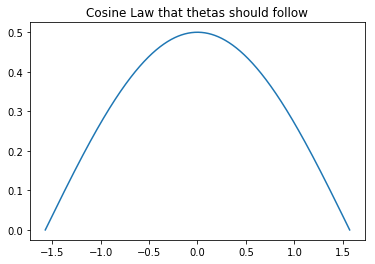

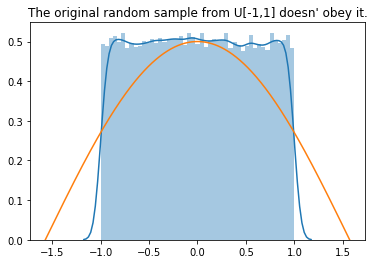

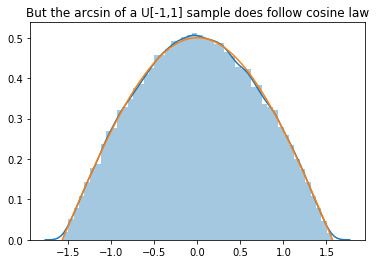

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

x = np.linspace(-np.pi/2, np.pi/2, 1000)
y = np.cos(x)/2
plt.plot(x,y)
plt.title("Cosine Law that thetas should follow")
plt.show()

a = np.random.uniform(low=-1, high=1, size=100000)
sns.distplot(a)
plt.plot(x,y)
plt.title("The original random sample from U[-1,1] doesn' obey it.")
plt.show()

phi = np.arcsin(a)
sns.distplot(phi)
plt.plot(x,y)
plt.title("But the arcsin of a U[-1,1] sample does follow cosine law")
plt.show()

## Improved version of Day 3 code

In [0]:
# Improved versions of the code from day 3

import numpy as np
import matplotlib.pyplot as plt


# improvements to draw include
#  - draw trails
#  - specify how many steps to plot
#  - pass in ax so we can overlay multiple runs

def draw(state, steps=None, ax=None):
    if state['POS'].ndim > 1:
        pos_hist = state['POS'][:steps]   # plot the first "steps"
        vel_hist = state['VEL'][:steps]   # plot the first "steps"
        pos = pos_hist[-1]  # the last state position
        vel = vel_hist[-1]  # the last state velocity
        draw_trails = True
    else:  # if only given the last state, we can't draw the trails
        pos = state['POS']  # the last state position
        vel = state['VEL']  # the last state velocity
        draw_trails = False
    
    if ax is None:   # May pass in ax to overlay plots
        fig, ax = plt.subplots(figsize=(5,5))

    # Trace box top-right, top-left, bottom-left, bottom-right, top-right
    s = side
    X = [s,-s,-s, s, s]
    Y = [s, s,-s,-s, s]
    box = ax.plot(X, Y)


    # Trace scatterer
    thetas = np.linspace(0, 2*np.pi)
    U = np.array([np.cos(thetas), np.sin(thetas)])
    pts = U * scatterer_radius
    scatterer = ax.fill_between(pts[0], pts[1])


    # Trace particle
    thetas = np.linspace(0, 2*np.pi)
    U = np.array([np.cos(thetas), np.sin(thetas)])
    pts = (U.T * particle_radius + pos).T
    particle = ax.plot(pts[0], pts[1])


    # Draw arrow for velocity
    ax.annotate("", xy=pos, xytext=pos+vel, arrowprops=dict(arrowstyle="<-"))
    
    
    # Draw trails
    if draw_trails:
        ax.plot(pos_hist[:,0], pos_hist[:,1])

    ax.set_aspect('equal')
    return ax


## Changes to initialize - arcsin of phi so we follow the cosine law
def initialize():
    # particle's initial position will be against the scatterer at angle theta to the positive x-axis
    theta = np.random.rand() * np.pi / 4  
    pos = np.array([np.cos(theta), np.sin(theta)]) * (particle_radius + scatterer_radius)


    # particle's initial velocity will be at angle phi to the normal vector at intial position
    a = np.random.rand()  # between 0 and 1
    a = 2*a - 1  # between -1 and +1
#     phi =  a * np.pi / 2  #between -pi/2 and +pi/2
    phi =  np.arcsin(a)  # Follows the cosine law, the invariant measure for the billiard map


    # Now, we need to get a normal vector to the scatterer at intitial position.
    n = pos.copy()

    # But we want it to have length 1 (unit vector).
    n /= np.linalg.norm(n)
   

    # Now, we want to rotate it by angle phi.  So, create the rotation matrix.
    R = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]
                 ])

    # Apply it to n
    vel = R@n
    wall_idx = num_walls-1
    state = {'pos':pos, 'vel':vel, 'phi':phi, 'wall':wall_idx, 't':0}
    return state


## New today - helper function to record states and create the state_history object if needed
def record_state(state, idx, state_history=None):
    if state_history is None:  # create state_history
        state_history = {'POS':np.full(shape=(steps+1, dim), fill_value=np.inf), # steps x dim filled with infinity
                         'VEL':np.full(shape=(steps+1, dim), fill_value=np.inf),
                         'WALL':np.full(shape=steps+1, fill_value=num_walls),
                         'PHI':np.full(shape=steps+1, fill_value=np.inf),
                         'T':np.full(shape=steps+1, fill_value=0.0),
                        }
    state_history['POS'][idx] = state['pos'].copy()
    state_history['VEL'][idx] = state['vel'].copy()
    state_history['WALL'][idx] = state['wall']
    state_history['PHI'][idx] = state['phi']
    state_history['T'][idx] = state['t']
    
    return state_history

## New Code for Day 4

- When doing the homework last night, I found np.inf to be a bit more convenient than np.nan.
- %run -i "billiards/dynamics" pulls in my version of next_state from another file, so that I don't ruin it for you.
- Though we eventually need to select intital conditions randomly, it can be helpful to get the same "random" numbers each time you run it while writing and debugging code.  Use np.random.seed(any number).  Make sure to disable this when you run it "for real".

## Visualizing chaos

Chaos means that very similiar starts become very different very quickly.  We'll show this in the Sinai billiard by starting 2 particle at the same velocity and *almost* the same position.  Let's overlay their plots and see them diverge.

In [3]:
runs = []
for dx in [0.0, 0.1]:
    
    np.random.seed(3)  # produces the same thing every thing - easier for debugging

    steps = 50
    dim = 2
    num_walls = 5

    particle_radius = 1
    side = 10  # This is HALF the length of a side, which will go from -side to +side
    scatterer_radius = 2
    assert (scatterer_radius < side), "scatterer won't fit in the box"  # checks that the scatterer fits inside the box

    state = initialize()
    
    state['pos'][0] += dx
    
    state_history = record_state(state, 0)  # creates state_history because we didn't pass in state_history
    
    %run -i dynamics
    
    for i in range(steps):
        state = next_state(state)  # evolves the system forward one step

        ## record current state for later use
        state_history = record_state(state, i+1, state_history)
    runs.append(state_history)

<Figure size 432x288 with 0 Axes>

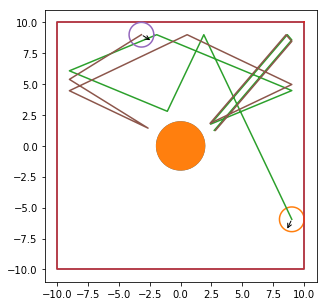

In [4]:
#@title Interactive {run: "auto"}
plot_steps = 10 #@param {type:"slider", min:1, max:50, step:1}

ax = draw(runs[0], steps=plot_steps)
ax = draw(runs[1], steps=plot_steps, ax=ax)
plt.show()

In [0]:
    # right wall 0
    sr = side - particle_radius
    try:
        DT[0] = (sr - pos[0]) / vel[0]
    except ZeroDivisionError:
        DT[0] = np.inf
        
        
n@vel

In [0]:
class MyClass():
    def __init__(self, name='billiards'):
        self.name = name
        self.x = 75
        
first_instance = MyClass()
second_instance = MyClass(name='tarleton')

print(first_instance.name)
print(second_instance.name)

print(first_instance.__dict__)
